## This script uses the Finetuning tutorial to transfer learn Faster R-CNN to Mask R-CNN, and follows up with applying initial pruning using Pytorch's pruning utility (torch.nn.utils.prune). Saving/loading is then performed.

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
# Overwrite in case of errors in using ! (magic)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip3 install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 458.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling tor

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)


# TorchVision Object Detection Finetuning Tutorial


.. tip::

    To get the most of this tutorial, we suggest using this
    [Colab Version](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb)_.
    This will allow you to experiment with the information presented below.


For this tutorial, we will be finetuning a pre-trained [Mask
R-CNN](https://arxiv.org/abs/1703.06870)_ model on the [Penn-Fudan
Database for Pedestrian Detection and
Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)_. It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.


.. note ::

    This tutorial works only with torchvision version >=0.16 or nightly.
    If you're using torchvision<=0.15, please follow
    [this tutorial instead](https://github.com/pytorch/tutorials/blob/d686b662932a380a58b7683425faa00c06bcf502/intermediate_source/torchvision_tutorial.rst).


## Defining the Dataset

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
``torch.utils.data.Dataset`` class, and implement ``__len__`` and
``__getitem__``.

The only specificity that we require is that the dataset ``__getitem__``
should return a tuple:

-  image: :class:`torchvision.tv_tensors.Image` of shape ``[3, H, W]``, a pure tensor, or a PIL Image of size ``(H, W)``
-  target: a dict containing the following fields

   -  ``boxes``, :class:`torchvision.tv_tensors.BoundingBoxes` of shape ``[N, 4]``:
      the coordinates of the ``N`` bounding boxes in ``[x0, y0, x1, y1]`` format, ranging from ``0``
      to ``W`` and ``0`` to ``H``
   -  ``labels``, integer :class:`torch.Tensor` of shape ``[N]``: the label for each bounding box.
      ``0`` represents always the background class.
   -  ``image_id``, int: an image identifier. It should be
      unique between all the images in the dataset, and is used during
      evaluation
   -  ``area``, float :class:`torch.Tensor` of shape ``[N]``: the area of the bounding box. This is used
      during evaluation with the COCO metric, to separate the metric
      scores between small, medium and large boxes.
   -  ``iscrowd``, uint8 :class:`torch.Tensor` of shape ``[N]``: instances with ``iscrowd=True`` will be
      ignored during evaluation.
   -  (optionally) ``masks``, :class:`torchvision.tv_tensors.Mask` of shape ``[N, H, W]``: the segmentation
      masks for each one of the objects

If your dataset is compliant with above requirements then it will work for both
training and evaluation codes from the reference script. Evaluation code will use scripts from
``pycocotools`` which can be installed with ``pip install pycocotools``.

.. note ::
  For Windows, please install ``pycocotools`` from [gautamchitnis](https://github.com/gautamchitnis/cocoapi)_ with command

  ``pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI``

One note on the ``labels``. The model considers class ``0`` as background. If your dataset does not contain the background class,
you should not have ``0`` in your ``labels``. For example, assuming you have just two classes, *cat* and *dog*, you can
define ``1`` (not ``0``) to represent *cats* and ``2`` to represent *dogs*. So, for instance, if one of the images has both
classes, your ``labels`` tensor should look like ``[1, 2]``.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a ``get_height_and_width``
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
``__getitem__`` , which loads the image in memory and is slower than if
a custom method is provided.

### Writing a custom dataset for PennFudan

Let’s write a dataset for the PennFudan dataset. After [downloading and
extracting the zip
file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)_, we
have the following folder structure:

::

   PennFudanPed/
     PedMasks/
       FudanPed00001_mask.png
       FudanPed00002_mask.png
       FudanPed00003_mask.png
       FudanPed00004_mask.png
       ...
     PNGImages/
       FudanPed00001.png
       FudanPed00002.png
       FudanPed00003.png
       FudanPed00004.png

Here is one example of a pair of images and segmentation masks

<img src="file://../../_static/img/tv_tutorial/tv_image01.png">

<img src="file://../../_static/img/tv_tutorial/tv_image02.png">

So each image has a corresponding
segmentation mask, where each color correspond to a different instance.
Let’s write a :class:`torch.utils.data.Dataset` class for this dataset.
In the code below, we are wrapping images, bounding boxes and masks into
``torchvision.TVTensor`` classes so that we will be able to apply torchvision
built-in transformations ([new Transforms API](https://pytorch.org/vision/stable/transforms.html))
for the given object detection and segmentation task.
Namely, image tensors will be wrapped by :class:`torchvision.tv_tensors.Image`, bounding boxes into
:class:`torchvision.tv_tensors.BoundingBoxes` and masks into :class:`torchvision.tv_tensors.Mask`.
As ``torchvision.TVTensor`` are :class:`torch.Tensor` subclasses, wrapped objects are also tensors and inherit the plain
:class:`torch.Tensor` API. For more information about torchvision ``tv_tensors`` see
[this documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).



## Downloading the data

In [ ]:
import subprocess
import os
if not os.path.exists('./PennFudanPed.zip'):
    # Use subprocess to run the wget command
    subprocess.run(['wget', 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip', '-O', './PennFudanPed.zip'])
else:
    print(f"The file PennFudanPed.zip already exists.")
if not os.path.exists('./PennFudanPed'):
    # Unzipping files
    !unzip PennFudanPed.zip
else:
    print(f"The file PennFudanPed.zip should already been unzipped.")

The file PennFudanPed.zip already exists.
The file PennFudanPed.zip should already been unzipped.


In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That’s all for the dataset. Now let’s define a model that can perform
predictions on this dataset.

## Defining your model

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870)_, which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497)_. Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

<img src="file://../../_static/img/tv_tutorial/tv_image03.png">

Mask R-CNN adds an extra branch
into Faster R-CNN, which also predicts segmentation masks for each
instance.

<img src="file://../../_static/img/tv_tutorial/tv_image04.png">

There are two common
situations where one might want
to modify one of the available models in TorchVision Model Zoo. The first
is when we want to start from a pre-trained model, and just finetune the
last layer. The other is when we want to replace the backbone of the
model with a different one (for faster predictions, for example).

Let’s go see how we would do one or another in the following sections.

### 1 - Finetuning from a pretrained model

Let’s suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 146MB/s]


### 2 - Modifying the model to add a different backbone



In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.7MB/s]


### Object detection and instance segmentation model for PennFudan Dataset

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That’s it, this will make ``model`` be ready to be trained and evaluated
on your custom dataset.

## Putting everything together

In ``references/detection/``, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
``references/detection/engine.py`` and ``references/detection/utils.py``.
Just download everything under ``references/detection`` to your folder and use them here.
On Linux if you have ``wget``, you can download them using below commands:



In [ ]:
if not os.path.exists('./engine.py'):
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
  os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1466, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0132, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0197, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0007, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 173MB/s]


In [ ]:
flag_train = 1
model_path = './original_model.pth'
if os.path.exists(model_path):
    # Set training flag to 0 if model exists
    flag_train = 0

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if flag_train:
  # let's train it for 5 epochs
  num_epochs = 5

  for epoch in range(num_epochs):
      # train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader_test, device=device)
else:
  # Load transfer learnt model
  model = get_model_instance_segmentation(num_classes)
  model.load_state_dict(torch.load(model_path))
  model.to(device)

Epoch: [0]  [ 0/60]  eta: 0:02:47  lr: 0.000090  loss: 2.9507 (2.9507)  loss_classifier: 0.5891 (0.5891)  loss_box_reg: 0.2491 (0.2491)  loss_mask: 2.1011 (2.1011)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 2.7879  data: 0.2435  max mem: 3240
Epoch: [0]  [10/60]  eta: 0:00:36  lr: 0.000936  loss: 1.5010 (1.8994)  loss_classifier: 0.4851 (0.4261)  loss_box_reg: 0.3054 (0.3149)  loss_mask: 0.8004 (1.1298)  loss_objectness: 0.0161 (0.0229)  loss_rpn_box_reg: 0.0043 (0.0056)  time: 0.7350  data: 0.0277  max mem: 3240
Epoch: [0]  [20/60]  eta: 0:00:25  lr: 0.001783  loss: 0.8065 (1.2742)  loss_classifier: 0.2010 (0.2852)  loss_box_reg: 0.2438 (0.2604)  loss_mask: 0.3006 (0.7040)  loss_objectness: 0.0160 (0.0192)  loss_rpn_box_reg: 0.0036 (0.0055)  time: 0.5191  data: 0.0062  max mem: 3240
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.5299 (1.0275)  loss_classifier: 0.0998 (0.2205)  loss_box_reg: 0.1695 (0.2445)  loss_mask: 0.2033 (0.5405)  loss_ob

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify

<img src="file://../../_static/img/tv_tutorial/tv_image05.png">




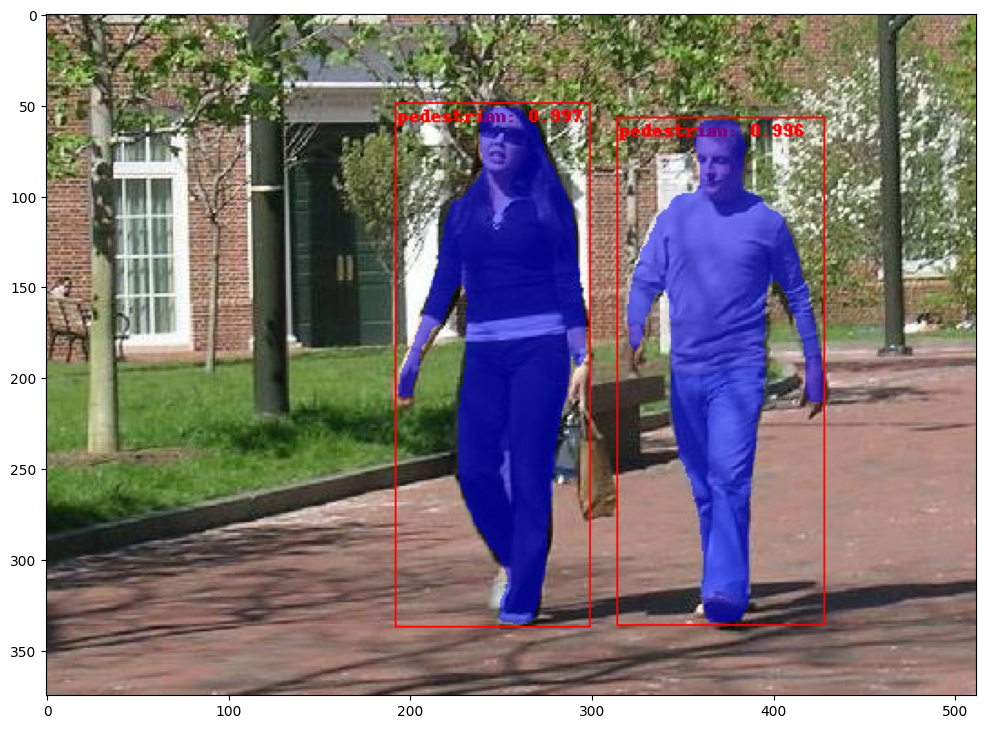

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("./PennFudanPed/PNGImages/PennPed00095.png")
# image = read_image("../_static/img/tv_tutorial/tv_image05.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
# Save the model if it was trained
if flag_train:
  torch.save(model.state_dict(), model_path)

The results look good!

## Wrapping up

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For
that, you wrote a ``torch.utils.data.Dataset`` class that returns the
images and the ground truth boxes and segmentation masks. You also
leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to
perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check ``references/detection/train.py``, which is present in
the torchvision repository.

You can download a full source file for this tutorial
[here](https://pytorch.org/tutorials/_static/tv-training-code.py)_.


## Attempt at doing a quick Pytorch pruning (Followed tutorial on https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

We note that there is an issue with Pytorch pruning, as the algorithm produces a mask which prunes the different branches, and the model actually became bigger. remove was used to remove the branches, but the space is not really saved in this version, hence to resort to other options.

In [ ]:
import copy
test_model = copy.deepcopy(model)

In [ ]:
print(test_model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
flag_prune = 1
prune_path = './pruned_model.pth'
if os.path.exists(prune_path):
    # Use subprocess to run the wget command
    flag_prune = 0


In [ ]:
if flag_prune:
  # Prune 50% of connections in all 2D-conv layers and 80% in all linear layers
  for name, module in test_model.named_modules():
      if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          # Apply your new pruning scheme
          prune.l1_unstructured(module, name='weight', amount=0.5 if isinstance(module, torch.nn.Conv2d) else 0.5)
          prune.remove(module, "weight")
else:
  test_model = get_model_instance_segmentation(num_classes)
  checkpoint = torch.load(prune_path)
  test_model.load_state_dict(checkpoint['model_state_dict'])
  test_model.to(device)

  # Apply pruning to the loaded model using the saved configuration
  for name, module, param_name in checkpoint['pruning_config']:
      prune.l1_unstructured(module, name=param_name, amount=0.5 if isinstance(module, torch.nn.Conv2d) else 0.5)

print(dict(test_model.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var', 'backbone.body.layer1.0.bn1.weight', 'backbone.body.layer1.0.bn1.bias', 'backbone.body.layer1.0.bn1.running_mean', 'backbone.body.layer1.0.bn1.running_var', 'backbone.body.layer1.0.bn2.weight', 'backbone.body.layer1.0.bn2.bias', 'backbone.body.layer1.0.bn2.running_mean', 'backbone.body.layer1.0.bn2.running_var', 'backbone.body.layer1.0.bn3.weight', 'backbone.body.layer1.0.bn3.bias', 'backbone.body.layer1.0.bn3.running_mean', 'backbone.body.layer1.0.bn3.running_var', 'backbone.body.layer1.0.downsample.1.weight', 'backbone.body.layer1.0.downsample.1.bias', 'backbone.body.layer1.0.downsample.1.running_mean', 'backbone.body.layer1.0.downsample.1.running_var', 'backbone.body.layer1.1.bn1.weight', 'backbone.body.layer1.1.bn1.bias', 'backbone.body.layer1.1.bn1.running_mean', 'backbone.body.layer1.1.bn1.running_var', 'backbone.body.layer1.1.bn2.weight', 'backbone.

In [ ]:
# Re-evaluation
evaluate(test_model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:20  model_time: 0.1724 (0.1724)  evaluator_time: 0.0145 (0.0145)  time: 0.4054  data: 0.2166  max mem: 3779
Test:  [49/50]  eta: 0:00:00  model_time: 0.0976 (0.1069)  evaluator_time: 0.0037 (0.0052)  time: 0.1112  data: 0.0033  max mem: 3779
Test: Total time: 0:00:06 (0.1229 s / it)
Averaged stats: model_time: 0.0976 (0.1069)  evaluator_time: 0.0037 (0.0052)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [ ]:
# Commented to save time
# # Refinement and re-evaluation
# num_epochs = 5

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(test_model, optimizer, data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(test_model, data_loader_test, device=device)

In [ ]:
#Save model if it was pruned
if flag_prune == 1:
  torch.save({
      'model_state_dict': test_model.state_dict(),
      'pruning_config': [(name, module, 'weight') for name, module in test_model.named_modules() if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear)],
  }, prune_path)

In [ ]:
# Check size of files
model_path = "./original_model.pth"
model_size = os.path.getsize(model_path)
print("File size (original model):", model_size, "bytes")

prune_path = "./pruned_model.pth"
prune_size = os.path.getsize(prune_path)
print("File size (pruned model):", prune_size, "bytes")

File size (original model): 176227213 bytes
File size (pruned model): 176271007 bytes


## Saving and loading model

In [ ]:
del model
del test_model
torch.cuda.empty_cache()

In [ ]:
# Load transfer learnt model
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

#Verifying outputs
evaluate(model.to(device), data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:18  model_time: 0.1570 (0.1570)  evaluator_time: 0.0142 (0.0142)  time: 0.3743  data: 0.2013  max mem: 3779
Test:  [49/50]  eta: 0:00:00  model_time: 0.0961 (0.1047)  evaluator_time: 0.0028 (0.0046)  time: 0.1091  data: 0.0032  max mem: 3779
Test: Total time: 0:00:05 (0.1194 s / it)
Averaged stats: model_time: 0.0961 (0.1047)  evaluator_time: 0.0028 (0.0046)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [ ]:
# Load pruned model
test_model = get_model_instance_segmentation(num_classes)
checkpoint = torch.load(prune_path)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.to(device)

# Apply pruning to the loaded model using the saved configuration
for name, module, param_name in checkpoint['pruning_config']:
    prune.l1_unstructured(module, name=param_name, amount=0.5 if isinstance(module, torch.nn.Conv2d) else 0.5)

#Verifying outputs
evaluate(test_model.to(device), data_loader_test, device=device)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:19  model_time: 0.1670 (0.1670)  evaluator_time: 0.0140 (0.0140)  time: 0.3861  data: 0.2032  max mem: 3779
Test:  [49/50]  eta: 0:00:00  model_time: 0.0980 (0.1055)  evaluator_time: 0.0036 (0.0049)  time: 0.1102  data: 0.0034  max mem: 3779
Test: Total time: 0:00:06 (0.1215 s / it)
Averaged stats: model_time: 0.0980 (0.1055)  evaluator_time: 0.0036 (0.0049)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [ ]:
# from google.colab import files
# files.download('original_model.pth')
# files.download('pruned_model.pth')

In [ ]:
!pip install gdown

In [ ]:
#Load previous model
import gdown
url = "https://drive.google.com/uc?id=1pnPHbofjOuVkTCfn7cH5OcVuJ59hIePR"
output = 'original_model.pth'  # Output file name
gdown.download(url, output, quiet=False)

url = "https://drive.google.com/uc?id=1OvMZNoLcJr5SMyremf76dMidDLWHeYRM"
output = 'pruned_model.pth'  # Output file name
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1pnPHbofjOuVkTCfn7cH5OcVuJ59hIePR
To: /content/original_model.pth
100%|██████████| 176M/176M [00:01<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OvMZNoLcJr5SMyremf76dMidDLWHeYRM
To: /content/pruned_model.pth
100%|██████████| 176M/176M [00:01<00:00, 93.1MB/s]


'pruned_model.pth'

In [ ]:
# Load transfer learnt model
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

#Verifying outputs
evaluate(model.to(device), data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:21  model_time: 0.1782 (0.1782)  evaluator_time: 0.0228 (0.0228)  time: 0.4332  data: 0.2303  max mem: 3779
Test:  [49/50]  eta: 0:00:00  model_time: 0.1098 (0.1139)  evaluator_time: 0.0050 (0.0070)  time: 0.1253  data: 0.0052  max mem: 3779
Test: Total time: 0:00:06 (0.1340 s / it)
Averaged stats: model_time: 0.1098 (0.1139)  evaluator_time: 0.0050 (0.0070)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max